In [22]:
import pandas as pd
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from numpy import interp
from sklearn.metrics import precision_recall_curve, auc, f1_score
from sklearn.model_selection import learning_curve, StratifiedKFold
from scipy.spatial import KDTree
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder

In [23]:
import nbformat

nb = nbformat.read("Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 407


## Student 2
### Name : Akash Amalan
### ID : 4682505

**How to run?**

- Make a new conda env with ```conda create -n cyber_data python=3.9```
- In the env ```pip install -r requirements.txt```

## 2. Imbalance task – 1 A4 – Individual

### Preprocessing

In [24]:
def conv(row):
    #Define conversion rates
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}

    #Convert amount to EUR
    return row['amount'] / (currency_dict[row['currencycode']] * 100)


def preprocess(df):
    #Prepare card id and ip id for plotting
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df['card_id'])
    df['card_id'] = card_enc.transform(df.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df['ip_id'])
    df['ip_id'] = ip_enc.transform(df.ip_id)

    #Encoding, Fill missing values
    df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
    df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
    df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'

    #Convert transaction amount to EUR
    df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)

    #Clean mail_id
    df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'
    enc6 = LabelEncoder()
    enc6.fit(df['mail_id'])
    df['mail_id'] = enc6.transform(df.mail_id)

    #Merge cvcresponsecode categories
    df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

    #Feature Engineering(create new feature)
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account', '', x))
    df['accountcode_cc'] = 0
    df.loc[(df['accountcode'] == 'UK'), 'accountcode_cc'] = 'GB'
    df.loc[(df['accountcode'] == 'Mexico'), 'accountcode_cc'] = 'MX'
    df.loc[(df['accountcode'] == 'Sweden'), 'accountcode_cc'] = 'SE'
    df.loc[(df['accountcode'] == 'APAC'), 'accountcode_cc'] = 'APAC'

    #Select features
    preprocessed = df[['issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode', 'shoppercountrycode',
                       'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
                       'mail_id', 'ip_id', 'card_id', 'amount_eur', 'countries_equal', 'label']]

    #Use ordinal encoding from pd.pandas
    data_converted = preprocessed.copy()
    data_converted['issuercountrycode'] = data_converted['issuercountrycode'].astype('category').cat.codes
    data_converted['txvariantcode'] = data_converted['txvariantcode'].astype('category').cat.codes
    data_converted['currencycode'] = data_converted['currencycode'].astype('category').cat.codes
    data_converted['shoppercountrycode'] = data_converted['shoppercountrycode'].astype('category').cat.codes
    data_converted['shopperinteraction'] = data_converted['shopperinteraction'].astype('category').cat.codes
    data_converted['cardverificationcodesupplied'] = data_converted['cardverificationcodesupplied'].astype(
        'category').cat.codes
    data_converted['cvcresponsecode'] = data_converted['cvcresponsecode'].astype('category').cat.codes
    data_converted['accountcode'] = data_converted['accountcode'].astype('category').cat.codes
    data_converted['mail_id'] = data_converted['mail_id'].astype('category').cat.codes
    data_converted['ip_id'] = data_converted['ip_id'].astype('category').cat.codes
    data_converted['card_id'] = data_converted['card_id'].astype('category').cat.codes

    return data_converted

def conv(row):
    #Define conversion rates
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}

    #Convert amount to EUR
    return row['amount'] / (currency_dict[row['currencycode']] * 100)


def preprocess(df):
    #Prepare card id and ip id for plotting
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df['card_id'])
    df['card_id'] = card_enc.transform(df.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df['ip_id'])
    df['ip_id'] = ip_enc.transform(df.ip_id)

    #Encoding, Fill missing values
    df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
    df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
    df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'

    #Convert transaction amount to EUR
    df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)

    #Clean mail_id
    df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'
    enc6 = LabelEncoder()
    enc6.fit(df['mail_id'])
    df['mail_id'] = enc6.transform(df.mail_id)

    #Merge cvcresponsecode categories
    df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

    #Feature Engineering(create new feature)
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account', '', x))
    df['accountcode_cc'] = 0
    df.loc[(df['accountcode'] == 'UK'), 'accountcode_cc'] = 'GB'
    df.loc[(df['accountcode'] == 'Mexico'), 'accountcode_cc'] = 'MX'
    df.loc[(df['accountcode'] == 'Sweden'), 'accountcode_cc'] = 'SE'
    df.loc[(df['accountcode'] == 'APAC'), 'accountcode_cc'] = 'APAC'

    #Select features
    preprocessed = df[['issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode', 'shoppercountrycode',
                       'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
                       'mail_id', 'ip_id', 'card_id', 'amount_eur', 'countries_equal', 'label']]

    #Use ordinal encoding from pd.pandas
    data_converted = preprocessed.copy()
    data_converted['issuercountrycode'] = data_converted['issuercountrycode'].astype('category').cat.codes
    data_converted['txvariantcode'] = data_converted['txvariantcode'].astype('category').cat.codes
    data_converted['currencycode'] = data_converted['currencycode'].astype('category').cat.codes
    data_converted['shoppercountrycode'] = data_converted['shoppercountrycode'].astype('category').cat.codes
    data_converted['shopperinteraction'] = data_converted['shopperinteraction'].astype('category').cat.codes
    data_converted['cardverificationcodesupplied'] = data_converted['cardverificationcodesupplied'].astype(
        'category').cat.codes
    data_converted['cvcresponsecode'] = data_converted['cvcresponsecode'].astype('category').cat.codes
    data_converted['accountcode'] = data_converted['accountcode'].astype('category').cat.codes
    data_converted['mail_id'] = data_converted['mail_id'].astype('category').cat.codes
    data_converted['ip_id'] = data_converted['ip_id'].astype('category').cat.codes
    data_converted['card_id'] = data_converted['card_id'].astype('category').cat.codes

    return data_converted


### Miscellaneous:
Extra classes for training and plotting

In [27]:
class Trainer:

    def __init__(self,  X_train, y_train, X_test, y_test, random_state=30):
        """
        Initializes the Trainier with several machine learning models
        :param random_state: for determinism
        """
        self.random_state = random_state
        self.svc = svm.LinearSVC(random_state=self.random_state, dual=True, max_iter=5000)
        self.rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=self.random_state)
        self.lr = LogisticRegression(solver='newton-cholesky', C=100, n_jobs=-1, random_state=self.random_state)
        self.black_box = BaggingClassifier(estimator=self.lr, n_estimators=10, random_state=200, n_jobs=-1)
        self.white_box = self.lr
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def train_black_box(self):
        """
        Trains the 'black_box' model (a BaggingClassifier) on provided training data.
        :param X_train: X_train
        :param y_train: y_train
        :return: trained model
        """
        self.black_box.fit(self.X_train, self.y_train)

    def get_block_box_auc(self):
        """
        Calculates and returns the ROC AUC score for the 'black_box' model
        :param X_test: X_test
        :param y_test: y_test
        :return: roc_auc_score
        """
        bagging_proba = self.black_box.predict_proba(self.X_test)
        return roc_auc_score(self.y_test, bagging_proba[:, 1])

    def get_auc(self):
        """
        Calculates and returns the ROC AUC scores for all 3 models
        :param X_test: X_test
        :param y_test: y_test
        :return: scores
        """

        y_proba_svc = self.svc._predict_proba_lr(self.X_test)
        y_probar_rfc = self.rfc.predict_proba(self.X_test)
        y_proba_lr = self.lr.predict_proba(self.X_test)

        fpr, tpr, _ = roc_curve(self.y_test, y_proba_svc[:, 1])
        roc_auc_svc = roc_auc_score(self.y_test, y_proba_svc[:, 1])  # Calculate ROC AUC score

        fpr, tpr, _ = roc_curve(self.y_test, y_probar_rfc[:, 1])
        roc_auc_rfc = roc_auc_score(self.y_test, y_probar_rfc[:, 1])  # Calculate ROC AUC score

        fpr, tpr, _ = roc_curve(self.y_test, y_proba_lr[:, 1])
        roc_auc_lr = roc_auc_score(self.y_test, y_proba_lr[:, 1])  # Calculate ROC AUC score

        return roc_auc_svc, roc_auc_rfc, roc_auc_lr

    def train_svc_rf_lr_classifiers(self):
        """
        Trains on all 3 classifiers
        :param X_train: X_train
        :param y_train: y_train
        :return: trained classifiers
        """

        #SVC
        self.svc.fit(self.X_train, self.y_train)
        print("Finished training on SVC")

        #Random Forest
        self.rfc.fit(self.X_train, self.y_train)
        print("Finished training on RFC")

        #LR
        self.lr.fit(self.X_train, self.y_train)
        print("Finished training on LR")



In [30]:
class Plotter:

    def __init__(self, X, y):
        """
        Initializes the plotter with train dataset and labels
        :param X: X
        :param y: y
        """
        self.X = X
        self.y = y



def plot_sklearn_roc_curve( y_real, y_pred, title):
    """
    Plots the ROC curve for a specific model
    :param y_real: y_real
    :param y_pred: y_pred
    :param title: title of plot
    :return:
    """
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_auc = roc_auc_score(y_real, y_pred)  # Calculate ROC AUC score

    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5, 5)
    plt.plot([0, 1], [0, 1], color='g')

    plt.title(title)
    plt.text(0.6, 0.2, f"AUC = {roc_auc:.4f}", fontsize=12,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    plt.show()


def plot( models, X_test, y_test ):
    """
    Plots the Roc curve for all 3 models
    :param models:  models       #SVM, Random Forest, Logisitc Regression
    :param X_test: X_test
    :param y_test: y_test
    :return: plots
    """

    y_proba = models[0]._predict_proba_lr(X_test)
    y_probarfc = models[1].predict_proba(X_test)
    y_probalr = models[2].predict_proba(X_test)

    plot_sklearn_roc_curve(y_test, y_proba[:, 1], "SVM")
    plot_sklearn_roc_curve(y_test, y_probarfc[:, 1], "Random Forest")
    plot_sklearn_roc_curve(y_test, y_probalr[:, 1], "Logistic Regression")

    plt.figure(figsize=(10, 6))
    plt.suptitle("ROC Curve Analysis", fontsize=16)
    plt.show()


In [31]:
class SMOTE:
    def __init__(self, sampling_strategy=0.1, k=5, random_state=None):

        """
        Initializes Smote
        :param sampling_strategy:  fraction *  Samples of Majority
        :param N: The paper uses smote N%, I use a sampling strategy similar to that of IMBLEARN.
        :param k: Number of nearest Neighbours
        """
        self.sampling_strategy = sampling_strategy
        self.k = k
        self.random_state = random_state if random_state is not None else np.random.RandomState()

        if sampling_strategy > 1:
            raise Exception("sampling_strategy cannot be more than 1")

    def fit_resample(self, X, y):
        """
        Simililar to IMBLEARN method
        :param X: train_data
        :param y: train_labels
        :return: synthetic samples on top of original
        """
        # Identify the minority and majority class
        unique, counts = np.unique(y, return_counts=True)
        majority_class = unique[np.argmax(counts)]
        minority_class = unique[np.argmin(counts)]

        minority_samples = X[y == minority_class]
        majority_samples = X[y == majority_class]

        # Calculate the number of new synthetic samples(either using sampling strategy or without
        if isinstance(self.sampling_strategy, float):
            n_samples = int(len(majority_samples) * self.sampling_strategy) - len(minority_samples)
        else:
            n_samples = len(majority_samples)

        # Find k nearest neighbors of each minority sample (KDTree is efficient datastructure)
        kdtree = KDTree(minority_samples)

        # Generate synthetic samples
        synthetic_samples = []
        for i in range(n_samples):
            # Choose a random minority sample
            sample = minority_samples[self.random_state.randint(len(minority_samples))]

            # Choose a random one of its k nearest neighbors
            distances, neighbors = kdtree.query([sample], self.k)
            neighbor = minority_samples[self.random_state.choice(neighbors[0])]

            # Create a synthetic sample at a random point between the two as per slides
            synthetic_sample = sample + self.random_state.random() * (neighbor - sample)
            synthetic_samples.append(synthetic_sample)

        # Combine the original samples with the synthetic ones (attempt to get same number of samples in each class)

        X_res = np.vstack([X, np.array(synthetic_samples)])
        y_res = np.hstack([y, np.repeat(minority_class, n_samples)])

        return X_res, y_res

### 2a. Print ROC curves

Finished processing data
After applying smote we have: 
Number of samples with label 0: 151476
Number of samples with label 1: 151324


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


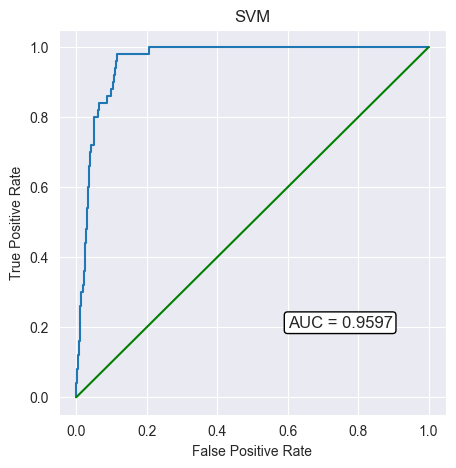

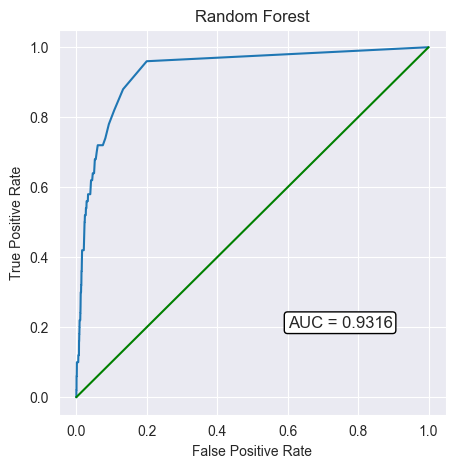

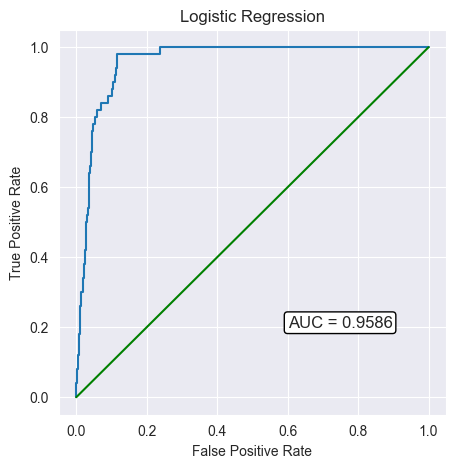

<Figure size 1000x600 with 0 Axes>

In [21]:
from sklearn.decomposition import PCA

pd_data = pd.read_csv('train_data.csv')
preprocessed = preprocess(pd_data)
data = preprocessed.to_numpy()

# Oversample and plot imbalanced dataset with SMOTE
data_transformed = preprocessed.to_numpy()
X = data_transformed[:, :-1]
y = data_transformed[:, -1].astype(int)

pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(0.99))])
Xt = pipe.fit_transform(X, y)

random_state = 200

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=random_state)
print("Finished processing data")

data = SMOTE(random_state=np.random.RandomState(random_state), k=5, sampling_strategy=0.999).fit_resample(X_train,
                                                                                                    y_train)  #My Smote
X_res, y_res = data

print('After applying smote we have: ')
print('Number of samples with label 0:', len(np.where(y_res == 0)[0]))
print('Number of samples with label 1:', len(np.where(y_res == 1)[0]))

t = Trainer(X_res, y_res, X_test, y_test)
t.train_svc_rf_lr_classifiers()
plot([t.svc, t.rfc, t.lr],X_test, y_test)

### 2b. Analyse the performance of the classifiers. Explain which method performs best.


I choose 3 classifiers, as you seen in the image above.Namely, SVM , Random Forest and Logistic Regression. Typically, the closer the corner points is to point (0.0, 1.0) the better it is for the classifier. This is because it is a pot of the true positive rate against the false positive rate. You have to maximimize the True positive rate while minimizing the false positive rate implying that (1,0) is indeed maximal. This is perhaps, better visualized, if you consider the image below:

<img src="images/Roc_curve.png" >


The image shows that the straight line from 0.0 to 1.0 is a random classifier anything above that threshold makes is a better classifier. All 3 classifiers seem to have performed relative well, (Note that SMOTE was only applied to the trainin set to get an unbiased evaluation on the Test set). Out of all 3 classifiers, it seems that SVM did best as it is closer to one, this is a bit harder to see. Therefore, I also calculated the AUC(area under the curve). AUC captures the area under the curve and compares the relation with the True Positive Rate and False positive rate. As you can see from the graphs above, SVM  performs best with an AUC of 0.9597.



### 2c. Is using SMOTE a good idea? Why (not)?

Finished processing data
without smote we have: 
Number of samples with label 0: 151476
Number of samples with label 1: 226


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


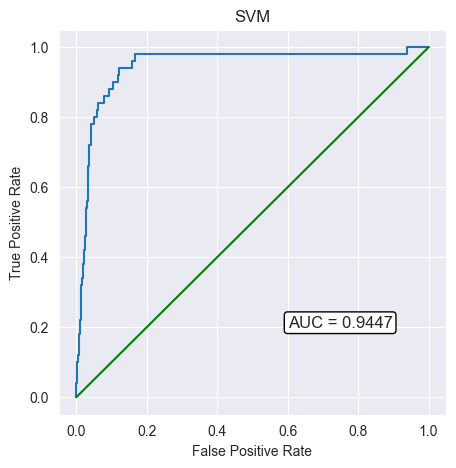

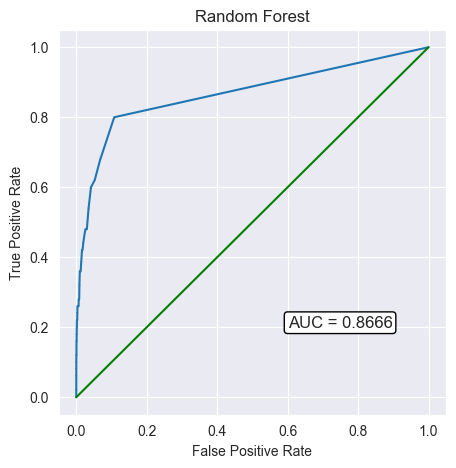

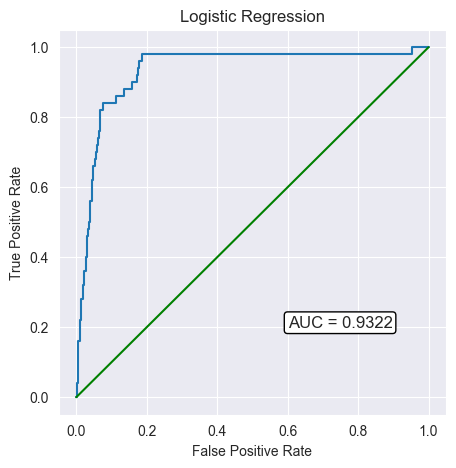

<Figure size 1000x600 with 0 Axes>

In [34]:
pd_data = pd.read_csv('train_data.csv')
preprocessed = preprocess(pd_data)
data = preprocessed.to_numpy()
X = data_transformed[:, :-1]
y = data_transformed[:, -1].astype(int)

pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(0.99))])
Xt = pipe.fit_transform(X, y)
random_state = 200

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=random_state)
print("Finished processing data")

print('without smote we have: ')
print('Number of samples with label 0:', len(np.where(y_train == 0)[0]))
print('Number of samples with label 1:', len(np.where(y_train == 1)[0]))

t = Trainer(X_train, y_train, X_test, y_test)
t.train_svc_rf_lr_classifiers()
plot([t.svc, t.rfc, t.lr],X_test, y_test)

The AUC scores the plot shows that without smore the classifiers are performing quite well. However, it is indeed true that SMOTE increases the AUC score a bit, for instance logistic regression was increased to 0.9586, SVM to 0.9557 and Random forest to 0.9216. The greatest increase was from  Random forest with a 5% increase. I initially expected SMOtING to give a tremendous increase, but this was not really the case. Note that I applied smote after standardisation step using preprocessing, this centered all features with mean 0 and standrd deviation 1 correcting for feature scaled. That said, applying smote as an oversampling technique is good for unbalanced data. But several papers point out that undersamplign the majority class is much better than oversampling the minority class. It is also important to note that we used a default k of 5, but perhaps using a different k will give much more better results. But it does improve a bit on the auc and roc curves, so I did not tune the k or the sampling strategy as in conclusion it does improve but not as much.